### Libraries

In [1]:
# For gee analyses
import ee 
import geemap.foliumap as geemap
from functions import *

# ee.Authenticate()
ee.Initialize()

# For plotting data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

%matplotlib inline

### Imports

In [2]:

# Import area of interest (AOI) IMPORTANT: keep the variable name to 'aoi' in order for the funcions to work
aoi = ee.FeatureCollection("projects/ee-nikolova100yana/assets/AOI_Salzachauen_buffer_150m_WGS84_33N")

# Insert list of desired image ids (or create your own collection). In this case an extensive list of ids is imported from functions.py
dates_list = import_dates_list()

# Import training and testing data (here we import data from GEE assets)
test_P = ee.FeatureCollection("projects/ee-nikolova100yana/assets/I3/Test_WGS33N_v3_gee")
train_P = ee.FeatureCollection("projects/ee-nikolova100yana/assets/I3/Train_WGS33N_v3_gee")

# State the name of the column containing label classes. In GEE classes have to be whole integers.
class_label = 'acronym_N' 

# Define the numeric and string variables of the landcover classes used
labels_str = ["PiAb", "PoBa", "FrEx", "AlIn", "QuRo", "AlGl", "SaAl"] 
labels_num = [1, 2, 3, 4, 5, 7, 8] 

# Filter training and testing data based on the provided classes
class_filter = ee.Filter.inList(class_label, labels_num)
train_P = train_P.filter(class_filter)
test_P = test_P.filter(class_filter)

## Main Script
### 1. Create image collection and multitep. stacked image with vegetation indeces

In [3]:
# Combine all the images you have imported into an image collection
imageCollection = ee.ImageCollection(dates_list) \
.select('B2', 'B3', 'B4','B5','B6','B7', 'B8A', 'B8', 'B11','B12')\
.map(lambda image: image.clip(aoi)) 

# print("Image collection", imageCollection.getInfo())

# Add vegetation indices bands to each image in the collection.
VegImageCollection = imageCollection.map(addIndices)
print("VegImageCOllection:", VegImageCollection.getInfo())

# # Apply the normalization to each image in the collection (optional)
# NormImageCollection = VegImageCollection.map(normalize)
# print("NormImageCollection", NormImageCollection.getInfo())

# Create a stack image for the image collection that includes vegetation indeces
# Stacking all images in the collection into one multi-band image
stackedImage = collectionToStackImage(VegImageCollection)
print("stackedImage: ", stackedImage.getInfo())



VegImageCOllection: {'type': 'ImageCollection', 'bands': [], 'features': [{'type': 'Image', 'bands': [{'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32633', 'crs_transform': [10, 0, 300000, 0, -10, 5400000]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32633', 'crs_transform': [10, 0, 300000, 0, -10, 5400000]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32633', 'crs_transform': [10, 0, 300000, 0, -10, 5400000]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [5490, 5490], 'crs': 'EPSG:32633', 'crs_transform': [20, 0, 300000, 0, -20, 5400000]}, {'id': 'B6', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [5490, 54

### Visualize the data

In this case we will explore the data using the two vegetation indeces

In [4]:
# Create a multitemporal image of singel index
ndvi_stackedImage = stackedImage.select(['.*_ndvi']) #'.*_greenness']
greenness_stackedImage = stackedImage.select(['.*_greenness'])

# Create panda dataframe for trining points based on the multitemporal image
ndvi_df = create_pd_df(ndvi_stackedImage, train_P, class_label)
print(ndvi_df.head())

greenness_df = create_pd_df(greenness_stackedImage, train_P, class_label)
print(greenness_df.head())


      date_int    date_str  label    values
2772   3192020  03/19/2020      1  0.850495
5052   3192020  03/19/2020      5  0.481646
952    3192020  03/19/2020      4  0.586326
5072   3192020  03/19/2020      5  0.570621
992    3192020  03/19/2020      4  0.593949
      date_int    date_str  label     values
2772   3192020  03/19/2020      1  15.175529
5052   3192020  03/19/2020      5   3.373539
952    3192020  03/19/2020      4   4.534625
5072   3192020  03/19/2020      5   4.386385
992    3192020  03/19/2020      4   4.614954


In [5]:
# Create a dictionary where each numeric label (key) is paired with each string label
label_map = {labels_num[i]:labels_str[i] for i in range (len(labels_num))}
print ("Resulting class dictionary is: " + str(label_map))

# Create an array with the colors you want to use
custom_palette = ["#2A4000", "#E69800", "#8400A8", "#4CE600", "#FF73DF", "#FFFF00", "#00FFC5"]
label_color_map = {labels_str[i]:custom_palette[i] for i in range (len(labels_str))}
print("Custom colour map legend: " + str(label_color_map))

Resulting class dictionary is: {1: 'PiAb', 2: 'PoBa', 3: 'FrEx', 4: 'AlIn', 5: 'QuRo', 7: 'AlGl', 8: 'SaAl'}
Custom colour map legend: {'PiAb': '#2A4000', 'PoBa': '#E69800', 'FrEx': '#8400A8', 'AlIn': '#4CE600', 'QuRo': '#FF73DF', 'AlGl': '#FFFF00', 'SaAl': '#00FFC5'}


Axes(0.125,0.11;0.775x0.77)


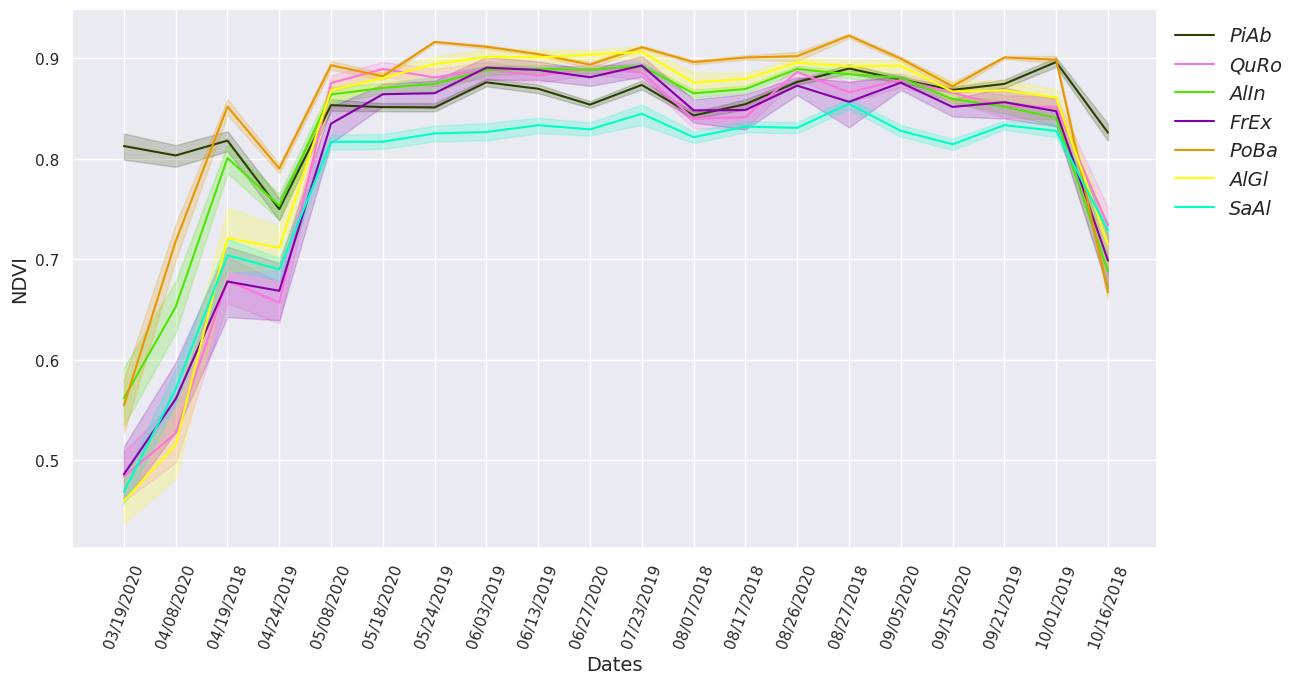

In [6]:
plot_timeseries(ndvi_df,label_map, label_color_map,'NDVI')

Axes(0.125,0.11;0.775x0.77)


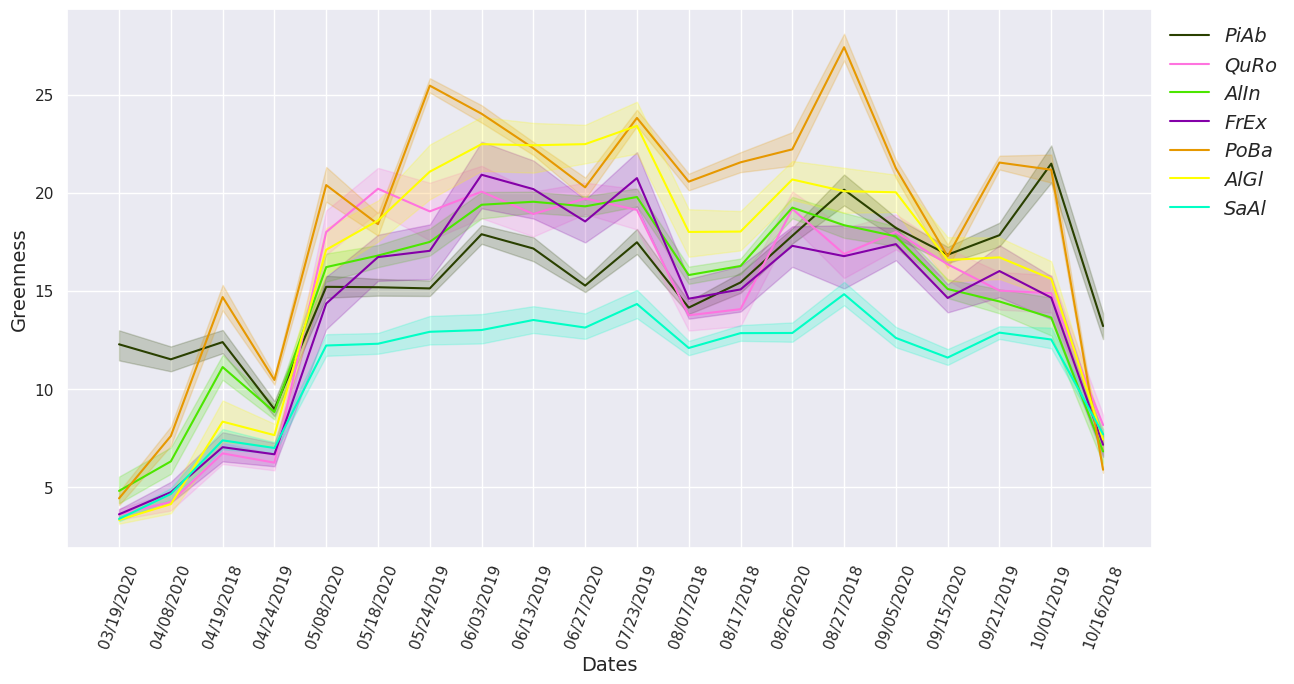

In [7]:
plot_timeseries(greenness_df,label_map, label_color_map,'Greenness')

### Plot NDVI vs Greenness

In [8]:
# Rename the 'value' column to 'ndvi' in df1 and 'greenness' in df2
ndvi_df.rename(columns={'values': 'ndvi'}, inplace=True)

greenness_df.rename(columns={'values': 'greenness'}, inplace=True)
merged_df = pd.merge(ndvi_df,greenness_df, left_index=True, right_index=True)
print(merged_df.head())



      date_int_x  date_str_x  label_x      ndvi Tree Species_x  date_int_y  \
2772     3192020  03/19/2020        1  0.850495           PiAb     3192020   
5052     3192020  03/19/2020        5  0.481646           QuRo     3192020   
952      3192020  03/19/2020        4  0.586326           AlIn     3192020   
5072     3192020  03/19/2020        5  0.570621           QuRo     3192020   
992      3192020  03/19/2020        4  0.593949           AlIn     3192020   

      date_str_y  label_y  greenness Tree Species_y  
2772  03/19/2020        1  15.175529           PiAb  
5052  03/19/2020        5   3.373539           QuRo  
952   03/19/2020        4   4.534625           AlIn  
5072  03/19/2020        5   4.386385           QuRo  
992   03/19/2020        4   4.614954           AlIn  


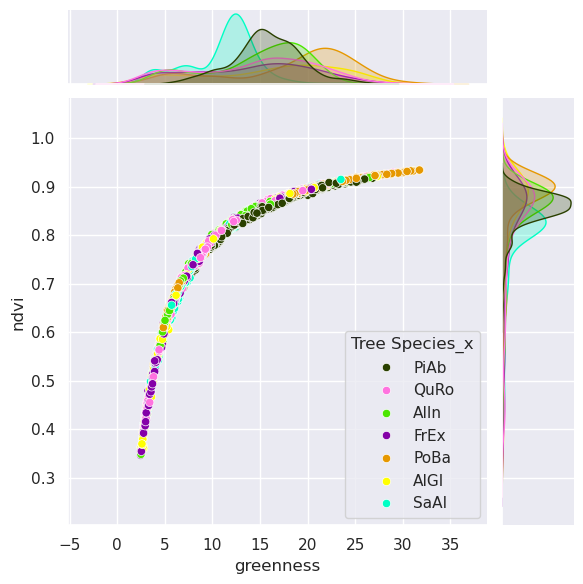

In [9]:
sns.jointplot(data=merged_df, x="greenness", y="ndvi", hue="Tree Species_x", palette=label_color_map)

### 2. Train and Apply RF Models
### 2.1 Stacked Image classification

In [10]:

# 1. Choose a composite (stacked multitemporal image)on which classification to be done
composite = stackedImage

classified, classifier = random_forest_classification(composite, train_P, class_label)

# palette = ['4682b4', '32cd32', '800080', 'ffa500', 'ff6347', '40e0d0'] #'ee82ee', # Violet#'f5deb3'  # Wheat]
# m.addLayer(classified, {'min': 0, 'max': 7, 'palette': palette}, '2020')

### 3 Accuracy assesment and feature importance

Confusion Matrix: [[20, 0, 1, 0, 0, 0, 0], [2, 11, 1, 1, 1, 2, 0], [0, 2, 6, 2, 3, 1, 2], [0, 1, 5, 13, 0, 2, 1], [3, 1, 3, 0, 11, 1, 0], [2, 0, 2, 0, 6, 5, 2], [0, 0, 0, 0, 1, 0, 19]]
Overall Accuracy: 0.6390977443609023
FScore: [0.8333333333333334, 0.6666666666666666, 0.35294117647058826, 0.6842105263157896, 0.5365853658536586, 0.35714285714285715, 0.8636363636363635]


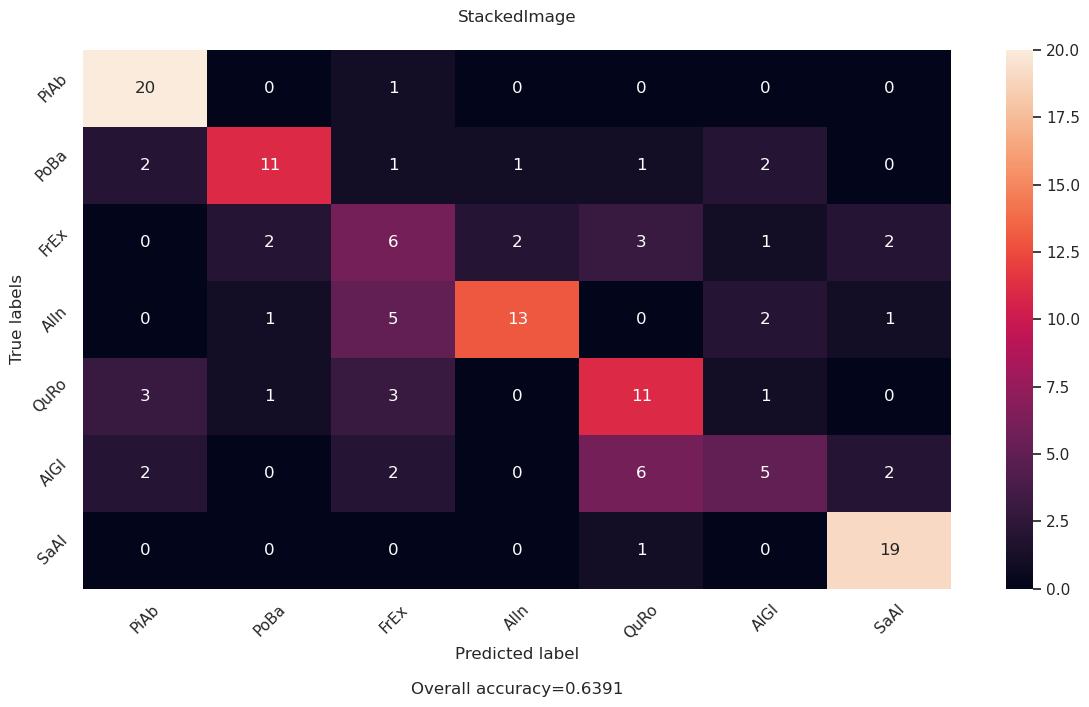

,Overall Accuracy,PiAb,PoBa,FrEx,AlIn,QuRo,AlGl,SaAl
0,0.64,0.83,0.67,0.35,0.68,0.54,0.36,0.86


In [11]:
ConfusionMatrix, overallaccuracy, fscore = accuracy_assesment(
    classified_image= classified, 
    testing_data= test_P, 
    class_label= class_label, 
    order= labels_num
    )

# Printing of confusion matrix and accuracy
print('Confusion Matrix:', ConfusionMatrix)
print('Overall Accuracy:', overallaccuracy)
print('FScore:', fscore)
# print('Producers Accuracy:', producer)
# print('Consumers accuracy:',consumer)
#----------------------------------------------------

plot_confmatrix(ConfusionMatrix,labels_str,overallaccuracy)

fscore_multitemp = dict(zip(labels_str,fscore))

multitemp_accuracy = {
    'Overall Accuracy': overallaccuracy,
    **fscore_multitemp
}


df_mulittemp = pd.DataFrame(multitemp_accuracy, index=[0]).round(2)
df_mulittemp



In [ ]:
#----------------------------------------------------------------------------
# 5. Plot Feature Importance into a heatmap
band_order = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12','greenness','ndvi']
width = 12.8 
height =  6.8

plot_importance( classifier, band_order, width, height)


In [ ]:
# m.centerObject(aoi,12)
# m

### 2.2 Single image classification

In [ ]:
# # 1. Choose a composite (stacked multitemporal image)on which classification to be done
# composite = stackedImage

#----------------------------------------------------------------------
#Display the chosen range of images from the sorted cloud collection
image_collection_list = VegImageCollection.toList(VegImageCollection.size())

# Get the size of the collection
collection_size = image_collection_list.size().getInfo()

# Here is an empty dictionary which will collect all the accuracies for each single date
single_date_accuracy = []

# Loop over the indices
for i in range(collection_size):
    image = ee.Image(image_collection_list.get(i))  # Get the image at index i
    date_str = image.date().format('MM/dd/yyyy').getInfo()  # Extract the date
    date_int = int(image.date().format('MMddyyyy').getInfo())
    classified, classifier = random_forest_classification(image, train_P, class_label)

    ConfusionMatrix, overallaccuracy, fscore = accuracy_assesment(
        classified_image= classified, 
        testing_data= test_P, 
        class_label= class_label, 
        order= labels_num
        )

    fscore_species = dict(zip(labels_str,fscore))

    single_date_entry = {
        'date_int': date_int,
        'Date': date_str,
        'Overall Accuracy': overallaccuracy,
        **fscore_species
    }

    single_date_accuracy.append(single_date_entry)

df3 = pd.DataFrame(single_date_accuracy)
df3